# collect data

In [3]:
corpus = ['golang Developers are intelligent', 
          'Managers are organized', 
          'Developers like javascript',
          'javascript Developers are intelligent',
          'we have wise Managers',
          'Developers will be wise Managers',
          'Managers are leaders who are wise and organized', 
          'leaders like Managers are organized',
          'wise Managers are organized leaders',
          'intelligent Developers like javascript',
          'Developers like golang'
]

# remove skip words

In [4]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be','and','are','at','like','of','then','to','the','my','have','we','who','are']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

corpus = remove_stop_words(corpus)

words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

# here we have word set by which we will have word vector

words

{'Developers',
 'Managers',
 'golang',
 'intelligent',
 'javascript',
 'leaders',
 'organized',
 'wise'}

# generate data

In [5]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

golang Developers intelligent
Managers organized
Developers javascript
javascript Developers intelligent
wise Managers
Developers wise Managers
Managers leaders wise organized
leaders Managers organized
wise Managers organized leaders
intelligent Developers javascript
Developers golang


In [6]:
df.head(10)

input        label
0       golang   Developers
1       golang  intelligent
2   Developers       golang
3   Developers  intelligent
4  intelligent       golang
5  intelligent   Developers
6     Managers    organized
7    organized     Managers
8   Developers   javascript
9   javascript   Developers

In [7]:
df.shape

(58, 2)

In [8]:
word2int

{'Developers': 6,
 'Managers': 0,
 'golang': 4,
 'intelligent': 7,
 'javascript': 2,
 'leaders': 1,
 'organized': 3,
 'wise': 5}

# Define Tensorflow Graph

In [9]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias

hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# train

In [12]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 25000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

('iteration 0 loss is : ', 2.232486)
('iteration 3000 loss is : ', 1.3952973)
('iteration 6000 loss is : ', 1.3524712)
('iteration 9000 loss is : ', 1.3355869)
('iteration 12000 loss is : ', 1.3276135)
('iteration 15000 loss is : ', 1.3224944)
('iteration 18000 loss is : ', 1.3187029)
('iteration 21000 loss is : ', 1.3155961)
('iteration 24000 loss is : ', 1.3126525)


In [14]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[-2.560307    1.8592253 ]
 [-4.587981   -2.0685034 ]
 [ 3.5821333   4.7478385 ]
 [-0.54394495 -0.3444388 ]
 [ 3.060595    4.216563  ]
 [-0.15587926 -0.3133229 ]
 [ 0.43238935 -0.15402693]
 [ 0.16348034  0.85346466]]


# word vector table

In [15]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

word        x1        x2
0     Managers -2.560307  1.859225
1      leaders -4.587981 -2.068503
2   javascript  3.582133  4.747838
3    organized -0.543945 -0.344439
4       golang  3.060595  4.216563
5         wise -0.155879 -0.313323
6   Developers  0.432389 -0.154027
7  intelligent  0.163480  0.853465

# word vector 2d chart

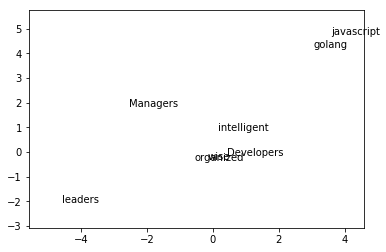

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()